### Imports

In [547]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
from pandas.plotting import scatter_matrix as scatter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import clone
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from utils import XyScaler

%matplotlib inline

### Data-prep Functions

In [463]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

def load_pickle(file_path):
    df = pd.read_pickle(file_path)
    return df

def clean_names(df):
    temp_liz = [name.lower().replace(" ","_") for name in df.columns]
    df.columns = temp_liz
    return df

def convert_dates(df, date_column, to_drop):
    ''' Input -- Pandas series of strings: formatted as yyyy-mm-dd
        Output -- Pandas series: integer number of days since the start of the data.
    '''
    old_column = date_column
    date_column = pd.to_datetime(date_column)
    df['date_delta'] = (date_column - date_column.min())  / np.timedelta64(1,'D')
    df.drop(to_drop, axis=1, inplace=True)
    return df

def convert_to_dummies(df, list_of_categorical_columns):
    ''' Input -- Pandas DataFrame
        Input -- List of Pandas Series -- Categorical column to be dummied
        Output -- DataFrame with the categorical column replaced with dummy columns
    '''
    for categorical_column in list_of_categorical_columns:
        dummied_column = pd.get_dummies(df[categorical_column], prefix='cat', drop_first=True)
        df = pd.concat([df, dummied_column], axis=1)
        df.drop(categorical_column, axis=1, inplace=True)
    return df

In [607]:
df = load_data('/Users/alanteran/galvanize/restaurant-revenue-prediction/data/train.csv')

In [609]:
df.head(15)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0
5,5,02/12/2010,Ankara,Big Cities,FC,6,6.0,4.5,7.5,8,...,5.0,0,0,0,0,0,0,0,0,5017319.0
6,6,10/11/2010,İstanbul,Big Cities,IL,2,3.0,4.0,4.0,1,...,3.0,4,5,2,2,3,5,4,4,5166635.0
7,7,06/21/2011,İstanbul,Big Cities,IL,4,5.0,4.0,5.0,2,...,2.0,0,0,0,0,0,0,0,0,4491607.0
8,8,08/28/2010,Afyonkarahisar,Other,IL,1,1.0,4.0,4.0,1,...,3.0,4,5,5,3,4,5,4,5,4952497.0
9,9,11/16/2011,Edirne,Other,IL,6,4.5,6.0,7.5,6,...,2.5,0,0,0,0,0,0,0,0,5444227.0


In [466]:
df = load_data('/Users/alanteran/galvanize/restaurant-revenue-prediction/data/train.csv')
df = clean_names(df)
df = convert_dates(df, df['open_date'], 'open_date')
df = convert_to_dummies(df, ['type', 'city_group'])
df = clean_names(df)
df = convert_to_dummies(df, ['p9', 'p13', 'p33'])
## df.info()
# df = df.query('revenue < 9560042.76')
# df = load_pickle('/Users/alanteran/galvanize/restaurant-revenue-prediction/src/dropped_influencers_and_vifs.pkl')
## df.to_pickle('Alans_df.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 53 columns):
id            137 non-null int64
city          137 non-null object
p1            137 non-null int64
p2            137 non-null float64
p3            137 non-null float64
p4            137 non-null float64
p5            137 non-null int64
p6            137 non-null int64
p7            137 non-null int64
p8            137 non-null int64
p10           137 non-null int64
p11           137 non-null int64
p12           137 non-null int64
p14           137 non-null int64
p15           137 non-null int64
p16           137 non-null int64
p17           137 non-null int64
p18           137 non-null int64
p19           137 non-null int64
p20           137 non-null int64
p21           137 non-null int64
p22           137 non-null int64
p23           137 non-null int64
p24           137 non-null int64
p25           137 non-null int64
p26           137 non-null float64
p27           137 non-null f

In [433]:
# print("p9 has {} unique values".format(len(df.p9.unique())))
# print("p13 has {} unique values".format(len(df.p13.unique())))
# print("p33 has {} unique values".format(len(df.p33.unique())))

### Split Data

In [434]:
# cities = df.pop('city')
# idee = df.pop('id')
y = df.pop('revenue')
X = df

In [435]:
# X = PCA(whiten=True, n_components=15).fit_transform(X)

In [423]:
# np.std(y)
# mean_y = np.mean(y)
# three_stds = np.std(y)*3
# print(mean_y)
# print(three_stds)
# print(mean_y+three_stds)
# print(mean_y-three_stds)
# # y = y[y< mean_y+three_stds]

In [472]:
def get_vifs(df):
    '''
    Input -- Pandas DataFrame, calculates the vifs for each variable in the DataFrame.
    Returns list of tuples: (column name, vif value)
    '''
    vifs = []
    cols = df.columns
    for index in range(df.shape[1]):
        vifs.append(round(variance_inflation_factor(df.values, index),2))
    return [(column, vif) for column, vif in zip(cols, vifs)]

In [473]:
vifs = get_vifs(X)
vifs.sort(key= lambda x:x[1])
vifs

/Users/alanteran/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/alanteran/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


[('date_delta', 1.3700000000000001),
 ('cat_other', 1.9399999999999999),
 ('p22', 2.0299999999999998),
 ('cat_5', 2.75),
 ('p2', 2.9399999999999999),
 ('p6', 3.4100000000000001),
 ('p4', 3.4300000000000002),
 ('p29', 3.4700000000000002),
 ('p17', 5.6600000000000001),
 ('p28', 5.6799999999999997),
 ('p23', 5.71),
 ('p11', 5.8899999999999997),
 ('p26', 6.1699999999999999),
 ('p37', 6.96),
 ('p27', 7.9299999999999997),
 ('p15', 10.41),
 ('p31', 13.630000000000001),
 ('cat_4', 15.93),
 ('p8', 16.600000000000001),
 ('p16', 22.219999999999999),
 ('p35', 25.780000000000001),
 ('p18', 30.859999999999999),
 ('cat_3', 32.759999999999998),
 ('p30', 33.890000000000001),
 ('cat_2', 35.579999999999998),
 ('p32', 36.409999999999997),
 ('cat_fc', inf),
 ('cat_il', inf),
 ('cat_8', inf),
 ('cat_10', inf),
 ('cat_4_0', inf),
 ('cat_5_0', inf),
 ('cat_6_0', inf),
 ('cat_7_5', inf),
 ('cat_5', nan),
 ('cat_6', nan)]

In [474]:
def plot_vifs(df):
    sorted_vifs = sorted(get_vifs(df), key=lambda x:x[1])
    N = len(sorted_vifs)
    features_sorted= []
    vifs_sorted= []
    for elem in sorted_vifs:
        features_sorted.append(elem[0])
        vifs_sorted.append(elem[1])
    features_sorted.reverse()
    vifs_sorted.reverse()

    ind = np.arange(N)
    width = 0.35
    fig, ax = plt.subplots(figsize=(10,4))
    rects1 = ax.bar(ind, vifs_sorted, width, color='r')

    ax.set_ylabel('Variance Inflation Factor')
    ax.set_title('Distribution of VIFs')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(features_sorted, rotation='90')
    ax.axhline(10, color='blue')

    return plt.show()

/Users/alanteran/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/alanteran/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


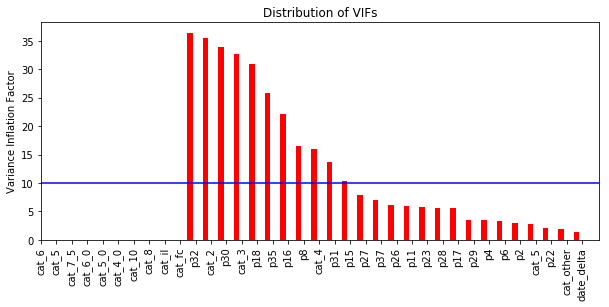

In [475]:
plot_vifs(X)

In [440]:
X_working, X_hold_out, y_working, y_hold_out = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_working, y_working, test_size=0.25)
np.mean(y_train)

4023880.579710145

In [441]:
vanilla_regression_model = sm.OLS(y_train, X_train).fit()
vanilla_rmse = np.sqrt(mse(y_test, vanilla_regression_model.predict(exog=X_test)))
vanilla_rmse

1739962.6684835183

In [442]:
# vanilla_regression_model.summary()

In [476]:
def my_rmse(y_true, y_pred):
    mse = ((y_true - y_pred)**2).mean()
    return np.sqrt(mse)

def my_cross_val_score(X_data, y_data, num_folds=3):
    kf = KFold(n_splits=num_folds)
    error = np.empty(num_folds)
    index = 0
    linear = LinearRegression()
    for train, test in kf.split(X_data):
        linear.fit(X_data[train], y_data[train])
        pred = linear.predict(X_data[test])
        error[index] = my_rmse(pred, y_data[test])
        index += 1
    return error

In [477]:
my_cross_val_score(X_working.values, y_working.values, num_folds=5)

array([ 2523834.62596899,  2332287.87075148,  2275769.71924841,
        4988450.18103687,  1550558.70328345])

In [481]:
LinearRegression().fit(X_train_std, y_train).score(X_train_std, y_train)

0.33809095999041039

NameError: name 'X_test_std' is not defined

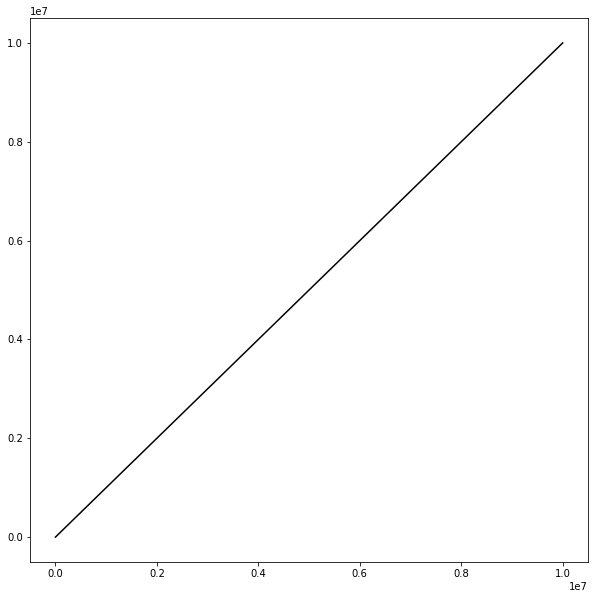

In [536]:
# Actual ys (y) vs predicted ys (x)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot([0,10000000], [0,10000000], "k-")
ax.scatter(LinearRegression().fit(X_train_std, y_train).predict(X_test_std), y_test)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.savefig('predicted_xaxis__vs_actual_yaxis_vanilla_lm.png');

In [571]:
def cv(X, y, base_estimator, n_folds, random_seed=154):

    kf = KFold(n_splits=n_folds, random_state=random_seed)
    test_cv_errors, train_cv_errors = np.empty(n_folds), np.empty(n_folds)
    for idx, (train, test) in enumerate(kf.split(X_train_std)):
        # Split into train and test
        X_cv_train, y_cv_train = X[train], y[train]
        X_cv_test, y_cv_test = X[test], y[test]
        # Standardize data.
        standardizer = XyScaler()
        standardizer.fit(X_cv_train, y_cv_train)
        X_cv_train_std, y_cv_train_std = standardizer.transform(X_cv_train, y_cv_train)
        X_cv_test_std, y_cv_test_std = standardizer.transform(X_cv_test, y_cv_test)
        # Fit estimator
        estimator = clone(base_estimator)
        estimator.fit(X_cv_train_std, y_cv_train_std)
        # Measure performance
        y_hat_train = estimator.predict(X_cv_train_std)
        y_hat_test = estimator.predict(X_cv_test_std)
        # Calclate the error metrics
        train_cv_errors[idx] = rss(y_cv_train_std, y_hat_train)
        test_cv_errors[idx] = rss(y_cv_test_std, y_hat_test)
    return train_cv_errors, test_cv_errors

def rss(y, y_hat):
    return np.mean((y  - y_hat)**2)

def train_at_various_alphas(X, y, model, alphas, n_folds=10, **kwargs):
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_fold_errors, test_fold_errors = cv(X, y, model(alpha=alpha, **kwargs), n_folds=n_folds)
        cv_errors_train.loc[:, alpha] = train_fold_errors
        cv_errors_test.loc[:, alpha] = test_fold_errors
    return cv_errors_train, cv_errors_test

def get_optimal_alpha(mean_cv_errors_test):
    alphas = mean_cv_errors_test.index
    optimal_idx = np.argmin(mean_cv_errors_test.values)
    optimal_alpha = alphas[optimal_idx]
    return optimal_alpha

In [572]:
# n_folds = 10
# train_cv_errors, test_cv_errors = cv(X_train.values, y_train.values, 
#                                      Ridge(alpha=0.5), n_folds=n_folds)

### LASSO 

In [573]:
lasso_alphas = np.logspace(-3, 1, num=250)
lasso_cv_errors_train, lasso_cv_errors_test = train_at_various_alphas(
    X_train.values, y_train.values, Lasso, lasso_alphas, max_iter=50000)

In [551]:
lasso_cv_errors_test.shape

(10, 250)

Text(0,0.5,'MSE')

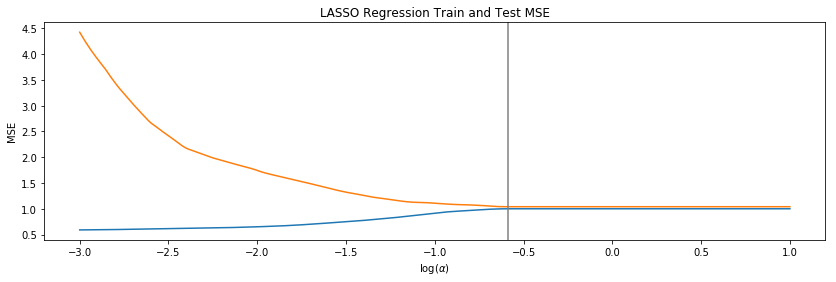

In [552]:
lasso_mean_cv_errors_train = lasso_cv_errors_train.mean(axis=0)
lasso_mean_cv_errors_test = lasso_cv_errors_test.mean(axis=0)

lasso_optimal_alpha = get_optimal_alpha(lasso_mean_cv_errors_test)
    
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_train)
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_test) 
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.set_title("LASSO Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")

In [531]:
lasso_models = []

for alpha in lasso_alphas:
    scaler = XyScaler()
    scaler.fit(X_train.values, y_train.values)
    X_train_std, y_train_std = scaler.transform(X_train.values, y_train.values)
    lasso = Lasso(alpha=alpha, tol=.01)
    lasso.fit(X_train_std, y_train_std)
    lasso_models.append(lasso)

Text(0,0.5,'Standardized Coefficient')

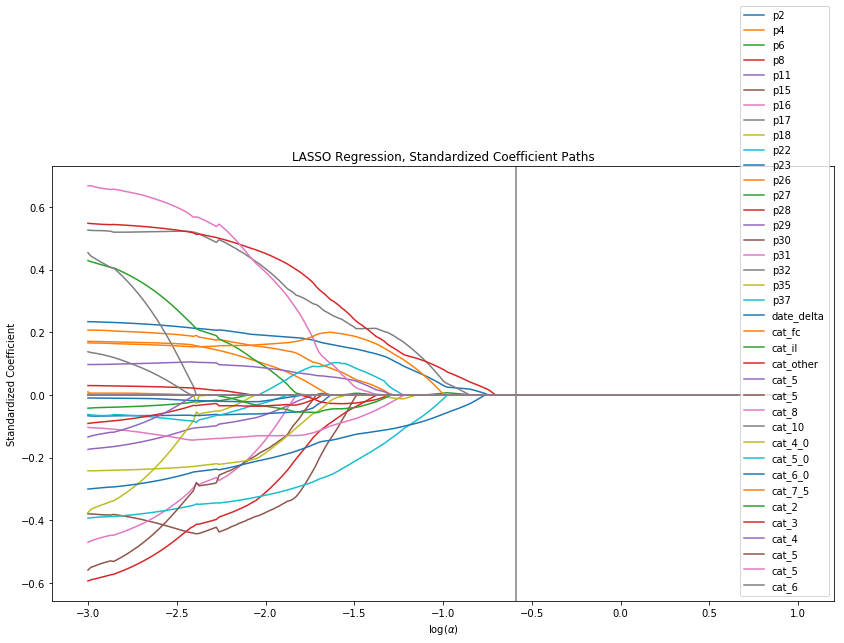

In [532]:
paths = pd.DataFrame(np.empty(shape=(len(lasso_alphas), len(X_train.columns))),
                     index=lasso_alphas, columns=X_train.columns)

for idx, model in enumerate(lasso_models):
    paths.iloc[idx] = model.coef_
    
fig, ax = plt.subplots(figsize=(14, 8))
for column in X_train.columns:
    path = paths.loc[:, column]
    ax.plot(np.log10(lasso_alphas), path, label=column)
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.legend(loc='lower right')
ax.set_title("LASSO Regression, Standardized Coefficient Paths")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("Standardized Coefficient")

In [592]:
clf = Lasso(alpha=3, tol=.01)

In [602]:
clf.fit(X_train_std, y_train)

/Users/alanteran/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.01, warm_start=False)

In [603]:
# print(clf.coef_)

In [604]:
# clf.predict(X_test)

In [605]:
LASSO_rmse = np.sqrt(mse(y_test, clf.predict(X_test)))

In [606]:
LASSO_rmse

2928814291.1158876

In [586]:
vanilla_rmse

1739962.6684835183

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot([0,10000000], [0,10000000], "k-")
ax.scatter(LinearRegression().fit(X_train_std, y_train).predict(X_test_std), y_test)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.savefig('predicted_xaxis__vs_actual_yaxis_vanilla_lm.png');